In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn.datasets import dump_svmlight_file
import random

# SageMaker ML Demo - Amazon Web Services

### Goals:

1) To build a model, using ML SageMaker. 

2) To predict the probability of a device failure, for a given set of features<br>

<h4>Hands-on: Device Failure Prediction, using AWS SageMaker</h4><br>
Input Features: date,device and attribute{1..9}<br>
Target Feature: failure<br>


# Data Collection

In [2]:
# Get the execution role for the notebook instance.
role = get_execution_role()

# AWS S3 Metadata; e.g. Name and location of the Dataset.
region = boto3.Session().region_name
bucket = 'ml-demo-device-failures'
file_location = 'device_failure.csv'

data_file_location = 'https://s3-{}.amazonaws.com/{}/{}'.format(region,bucket,file_location)
device_states=pd.read_csv(data_file_location)

In [3]:
# Visualising the data, ordered by date
device_states.date=pd.to_datetime(device_states.date)
device_states.sort_values('date',inplace=True)

In [4]:
# Dataset Sample
device_states.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
779,2015-01-01,W1F0Y13C,0,234318640,0,0,0,4,185772,0,0,3
778,2015-01-01,W1F0XKWR,0,89660704,0,0,0,7,30,0,0,0
777,2015-01-01,W1F0X7QX,0,162013456,0,0,0,12,217686,0,0,0
776,2015-01-01,W1F0X7PR,0,13138392,0,0,0,9,191343,0,0,0


# Data Visualization & Analysis

In [5]:
# How many failures there are?
device_states.groupby('failure').device.count()

failure
0    124388
1       106
Name: device, dtype: int64

In [6]:
# Analyse 10 random failures:
device_states[device_states.failure==1].head(10)

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
4885,2015-01-05,S1F0RRB1,1,48467332,64776,0,841,8,39267,56,56,1
6879,2015-01-07,S1F0CTDN,1,184069720,528,0,4,9,387871,32,32,3
8823,2015-01-09,W1F0PNA5,1,136429411,64784,0,406,30,224801,8,8,0
11957,2015-01-13,W1F13SRV,1,188251248,2040,0,0,6,39345,32,32,1
12668,2015-01-14,W1F1230J,1,220461296,0,0,0,14,325125,0,0,0
14734,2015-01-17,W1F0T034,1,154998752,1312,0,18,10,306996,0,0,0
15087,2015-01-18,S1F0GG8X,1,54292264,64736,0,160,11,192179,0,0,2
16257,2015-01-19,W1F15S4D,1,241813024,3528,0,74,6,106159,16,16,0
16223,2015-01-19,W1F0Z1W9,1,77877592,0,0,0,12,233238,0,0,0
16420,2015-01-19,Z1F0NVZA,1,21389544,0,0,60,10,209721,16,16,0


In [7]:
# attr1 and attr6: high NDV 
# while, atrr <> {1,6} probable categorical features.
for i in device_states.columns:
    print("For variable " + str(i) + ", there are " + str(len(device_states[i].unique())) + " unique values")

For variable date, there are 304 unique values
For variable device, there are 1168 unique values
For variable failure, there are 2 unique values
For variable attribute1, there are 123878 unique values
For variable attribute2, there are 558 unique values
For variable attribute3, there are 47 unique values
For variable attribute4, there are 115 unique values
For variable attribute5, there are 60 unique values
For variable attribute6, there are 44838 unique values
For variable attribute7, there are 28 unique values
For variable attribute8, there are 28 unique values
For variable attribute9, there are 65 unique values


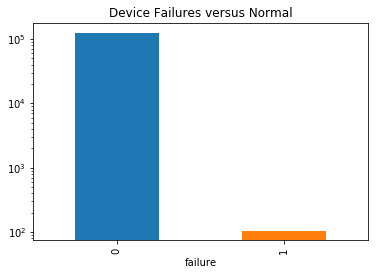

In [8]:
# How many failures there are:
df = device_states.groupby('failure').device.count()
df.plot(kind='bar',logy=True,title="Device Failures versus Normal")

In [9]:
# Correlation of the Features vs. our Target:
device_states.corr()['failure']

failure       1.000000
attribute1    0.001984
attribute2    0.052902
attribute3   -0.000948
attribute4    0.067398
attribute5    0.002270
attribute6   -0.000550
attribute7    0.119055
attribute8    0.119055
attribute9    0.001622
Name: failure, dtype: float64

Text(0,0.5,'failure')

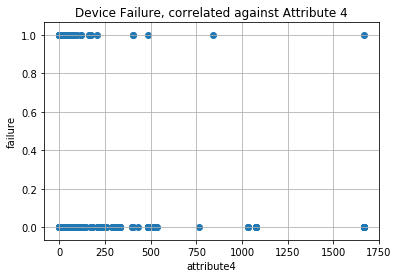

In [10]:
# Plotting the Correlation of feature 4, against Target:
plt.scatter(x=device_states.attribute4,y=device_states["failure"],label='attribute4')
plt.grid(True)
plt.title('Device Failure, correlated against Attribute 4')
plt.xlabel('attribute4')
plt.ylabel('failure')

Text(0,0.5,'failure')

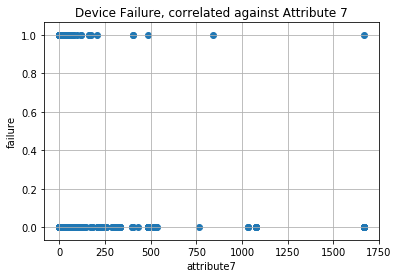

In [11]:
# Plotting the Correlation of feature 7, against Target:
plt.scatter(x=device_states.attribute4,y=device_states["failure"],label='attribute4')
plt.grid(True)
plt.title('Device Failure, correlated against Attribute 7')
plt.xlabel('attribute7')
plt.ylabel('failure')

Text(0.5,1,'Device Failures Over Time')

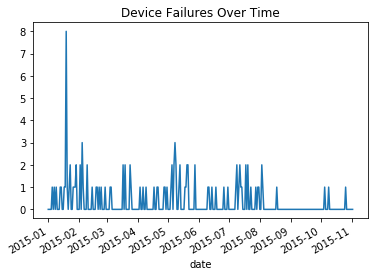

In [12]:
#check daily failure numbers
device_states.groupby('date').failure.sum().plot() 
plt.title('Device Failures Over Time')

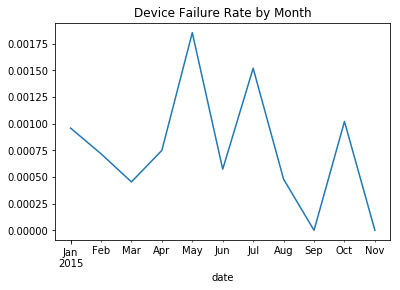

In [13]:
# Device Failure Rate by Month
check=device_states.copy()
check.set_index(['device','date'],inplace=True)
check.sort_index(inplace=True)
monthly_failure=check.resample('M',label='right',convention='end',level='date').failure.sum()
monthly_base=check.resample('M',label='right',
                            convention='end',level='date').failure.count()
monthly_rate=monthly_failure/monthly_base
monthly_rate.plot()
plt.title('Device Failure Rate by Month')
plt.show()

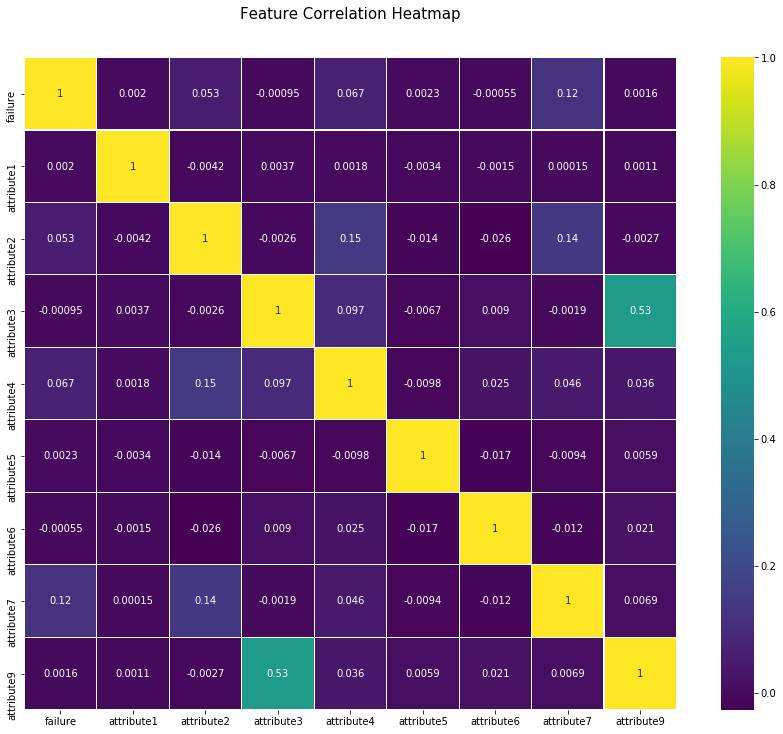

In [14]:
# Plotting the Feature Correlation:

cols = ["attribute1","attribute2","attribute3","attribute4","attribute5","attribute6","attribute7","attribute9"]
colormap = plt.cm.viridis
plt.figure(figsize = (16, 12))
plt.title('Feature Correlation Heatmap', y = 1.05, size  = 15)
sns.heatmap(device_states[["failure"] + cols].astype(float).corr(), 
            linewidth = 0.1, vmax = 1.0, square = True, cmap = colormap, linecolor = 'white', annot = True)
plt.show()

# Feature engineering

In [ ]:
#list the devices with failures
rs=1
random.seed(rs)
s_window=7 #short memory window
l_window=30 #long memory window

failed=device_states[device_states['failure']==1].device
failed.reset_index(drop=True,inplace=True)
device_states.loc[device_states['device']==failed[3],['date','failure']] 

#Explore attributes for failed and not failed devices

#first, for some failed devices, let's see how attributes 1~4 values might change 
#as they get closer to failure date
failed_sample=random.sample(failed.tolist(),5)
for i in range(5):
    fig,axes =plt.subplots(ncols=4,figsize=(16,4))
    fig.autofmt_xdate()
    for j in range(1,5):
    
        value=device_states.loc[device_states['device']==failed_sample[i],
                                 ['date','attribute'+str(j)]]
        rolling_mean=value['attribute'+str(j)].rolling(window=l_window, min_periods=5).mean()
        
        ax=axes[j-1]
        ax.plot(value['date'],value['attribute'+str(j)],'b')
        ax.plot(value['date'],rolling_mean,'r')
        ax.set_title('attribute'+str(j)+' for device'+failed[i])
        
    plt.show()

<br>Creating short and long term rolling mean and rolling std for some attributes

In [ ]:
for i in range(1,10):
    device_states['attribute'+str(i)+'_s_rolling_mean']=\
        device_states['attribute'+str(i)].rolling(window=s_window,min_periods=5,center=False).mean()
    device_states['attribute'+str(i)+'_l_rolling_mean']=\
        device_states['attribute'+str(i)].rolling(window=l_window, min_periods=15).mean()

    if (i in (1,6)):
        device_states['attribute'+str(i)+'_s_rolling_std']=\
            device_states['attribute'+str(i)].rolling(window=s_window, min_periods=5).std()
        device_states['attribute'+str(i)+'_l_rolling_std']=\
            device_states['attribute'+str(i)].rolling(window=l_window, min_periods=15).std()


Creating changes from the initial values

In [ ]:
temp=device_states.copy()
temp['initial_date']=temp.groupby('device')['date'].transform('min')
first_record=temp[temp['date']==temp['initial_date']]

for i in range(1,10):
    first_record=first_record.rename(columns={'attribute'+str(i):'initial_attribute'+str(i)})

first_record.drop(['failure','date','initial_date',
                   'attribute1_s_rolling_mean','attribute2_s_rolling_mean',
                   'attribute3_s_rolling_mean','attribute4_s_rolling_mean',
                   'attribute5_s_rolling_mean','attribute6_s_rolling_mean',
                   'attribute7_s_rolling_mean','attribute8_s_rolling_mean',
                   'attribute9_s_rolling_mean',
                   'attribute1_s_rolling_std','attribute6_s_rolling_std',
                   'attribute1_l_rolling_mean','attribute2_l_rolling_mean',
                   'attribute3_l_rolling_mean','attribute4_l_rolling_mean',
                   'attribute5_l_rolling_mean','attribute6_l_rolling_mean',
                   'attribute7_l_rolling_mean','attribute8_l_rolling_mean',
                   'attribute9_l_rolling_mean',
                   'attribute1_l_rolling_std','attribute6_l_rolling_std'],
                  axis=1,inplace=True)

diff=pd.merge(device_states,first_record,how='left',on='device')    
for i in range(1,10):
    diff['attribute'+str(i)+'_diff']=diff['attribute'+str(i)]-diff['initial_attribute'+str(i)]

diff.drop(['initial_attribute1','initial_attribute2',
                   'initial_attribute3','initial_attribute4','initial_attribute5',
                   'initial_attribute6','initial_attribute7','initial_attribute8',
                   'initial_attribute9'],axis=1,inplace=True)

In [ ]:
# single period change of attributes

diff.set_index(['device','date'],inplace=True)
diff.sort_index(inplace=True)
shift=diff.shift(1,axis=0) 
#move the previous period x to the next period, 
#since we can only use last period values for prediction

for i in range(1,10):
    shift=shift.rename(columns={'attribute'+str(i):'lag_attribute'+str(i)})
    
shift.drop(['failure','attribute1_s_rolling_mean','attribute2_s_rolling_mean',
                   'attribute3_s_rolling_mean','attribute4_s_rolling_mean',
                    'attribute5_s_rolling_mean','attribute6_s_rolling_mean',
                    'attribute7_s_rolling_mean','attribute8_s_rolling_mean',
                   'attribute9_s_rolling_mean','attribute1_s_rolling_std',
                    'attribute6_s_rolling_std','attribute1_l_rolling_mean',
                    'attribute2_l_rolling_mean','attribute3_l_rolling_mean',
                    'attribute4_l_rolling_mean','attribute5_l_rolling_mean',
                   'attribute6_l_rolling_mean','attribute7_l_rolling_mean',
                    'attribute8_l_rolling_mean','attribute9_l_rolling_mean',
                   'attribute1_l_rolling_std','attribute6_l_rolling_std',
                   'attribute1_diff','attribute2_diff','attribute3_diff',
                    'attribute4_diff','attribute5_diff','attribute6_diff',
                    'attribute7_diff','attribute8_diff',
                   'attribute9_diff'],axis=1,inplace=True)

diff2=pd.merge(diff,shift,how='left',right_index=True,left_index=True)
for i in range(1,10):
    diff2['attribute'+str(i)+'_change']=diff2['attribute'+str(i)]
    -diff2['lag_attribute'+str(i)]

### Shift Up the Next periods (Device Failure Label) as a Target Variable  for Prediction 
This dataset is now ready to be converted from temporal to a Cross-sectional dataset

In [ ]:
results1=diff2.shift(-1,axis=0)
results1=results1['failure']
results_1=results1.to_frame(name='failure_next_period')

final_modeling_set=pd.merge(diff2,results_1,how='left',
                            right_index=True,left_index=True)

final_modeling_set.drop(['failure','lag_attribute1','lag_attribute2','lag_attribute3','lag_attribute4',
              'lag_attribute5','lag_attribute6','lag_attribute7','lag_attribute8',
              'lag_attribute9'],axis=1,inplace=True)
final_modeling_set.rename(columns={'failure_next_period':'y'},inplace=True)
final_modeling_set.reset_index(inplace=True)

In [ ]:
final_modeling_set

## Splitting Training, Validation and Test Datasets
First 5 months is used for Model Training <br/>
1 month is used for Model Validation <br/>
The last 5 months is used for Model Testing

Files passed to XGBoost need to be in a specific format:
	1. No header row
	2. Outcome variable in the first column, features in the rest of the columns (there's no ability to drop them during the training process)
	3. All columns need to be numeric
	4. LibSVM format is recommended rather than csv                                                                                  

In [ ]:
import pandas_ml
### Dataset preparation
final_modeling_set.dropna(inplace=True)
final_modeling_set.reset_index(drop=True,inplace=True)
final_modeling_set['y']=final_modeling_set['y'].astype(int)
cols = final_modeling_set.columns.tolist()
cols = (cols[-1:] + cols[:-1])
final_modeling_set=final_modeling_set[cols]

train_data=final_modeling_set.loc[final_modeling_set.date<'2015-06-01',:]
train_data_X = train_data[np.setdiff1d(cols,['date','device','y'])]
train_data_y = train_data['y']

dump_svmlight_file(train_data_X,train_data_y,'train.dat',zero_based=True,multilabel=False)

In [ ]:
###SMOTE data balancing
"""df=pandas_ml.ModelFrame(train_data_X,train_data_y)
sampler=df.imbalance.combine.SMOTE()
sampler.out_step=0.5
train_data=df.fit_sample(sampler,df["y"])
train_data_X = train_data[np.setdiff1d(train_data.columns,['y'])]
train_data_y = train_data['y']

dump_svmlight_file(train_data_X,train_data_y,'train.dat',zero_based=True,multilabel=False)
"""

In [ ]:
validation_data=final_modeling_set.loc[(final_modeling_set.date>='2015-06-01') & (final_modeling_set.date<'2015-07-01'),:]
validation_data_X = validation_data[np.setdiff1d(cols,['date','device','y'])]
validation_data_y = validation_data['y']
dump_svmlight_file(validation_data_X,validation_data_y,'validation.dat',zero_based=True,multilabel=False)

testing_data=final_modeling_set.loc[final_modeling_set.date>='2015-07-01',:]
testing_data.to_csv("test.csv",index=False)

Sending the created Files to S3 locations(to be consumed by Model Training Process in Part 2)

In [ ]:
s3_input_train = boto3.Session().resource('s3').Bucket(bucket).Object('train/train.dat')
s3_input_train.upload_file('train.dat')

s3_input_validation = boto3.Session().resource('s3').Bucket(bucket).Object('validation/validation.dat')
s3_input_validation.upload_file('validation.dat')

s3_input_test = boto3.Session().resource('s3').Bucket(bucket).Object('test/test.csv')
s3_input_test.upload_file('test.csv')